# testing scrolling

In [46]:
# loading the packages

import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import numpy as np
from collections import Counter

# !pip install webdriver-manager
from webdriver_manager.chrome import ChromeDriverManager

# using for selenium 4
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager


from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

import nltk
# uncomment the following lines if you are running it for the first time
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import contractions
import requests
from wordcloud import WordCloud


import timm
from PIL import Image
from io import BytesIO
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image

import torch
import torch.nn as nn

import os
import pinecone

In [54]:
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY') or '513836a7-99b4-4ebe-b5e5-3d00d17f7910',
    environment=os.environ.get('PINECONE_ENVIRONMENT') or 'asia-southeast1-gcp-free'
)

index_name = 'AICU-BIKE-SEARCH-INDEX'.lower()

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=512,
        metric='cosine'
    )
    # wait for index to finish initialization
    while not pinecone.describe_index(index_name).status['ready']:
        time.sleep(1)

In [ ]:
service = ChromeService(executable_path=ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.get("https://www.carousell.sg/categories/sports-equipment-10/bicycles-parts-1900/bicycles-247?addRecent=false&canChangeKeyword=false&includeSuggestions=false&sc=0a0208301a0408bbe172220c0a0862696379636c657378012a110a095f64656c69766572793a02080078012a160a0b636f6c6c656374696f6e7312050a0332343778013204080378013a02180742060801100118004a08200128014001480150005a020801&search=bicycles&searchId=6Oyxkt&sort_by=3&tab=marketplace")


productList = []
time.sleep(2)
i = 0

scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
i = 1

MAX_TRIES = 10  # Set a maximum number of scrolling attempts in case of infinite scrolling pages.

tries = 0
previous_scroll_height = 0

MAX_SCROLLS = 10  # Change this value to the number of scrolls you want.

scroll_count = 0

while scroll_count < MAX_SCROLLS:
    # Scroll one screen height each time
    driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))
    time.sleep(scroll_pause_time)
    
    # Try to find the "Read More" button
    try:
        read_more_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div.D_Mw > div > button")))
        if read_more_button:
            print("Read more button clicked for the", i, "time")
            read_more_button.click()
            time.sleep(3)  # Wait after clicking the button for the content to load
    except:
        # If not found, then continue scrolling
        pass

    # Update the counter
    scroll_count += 1
    i += 1

for x in range(1, 3):
    products = driver.find_elements(By.CSS_SELECTOR, f"#main > div.D_Mf > div > section.D_Mr > div.D_Mw > div > div > div:nth-child({x}) > div")
    for product in products: 
        try:
            listing_link = product.find_element(By.CSS_SELECTOR, "div > div.D_zX.M_tF > a:nth-child(2)").get_attribute('href')
        except:
            try:
                listing_link = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a:nth-child(2)").get_attribute('href')
            except:
                listing_link = None


        try:
            product_name = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a:nth-child(2) > p.D_pw.D_ov.D_px.D_pA.D_pE.D_pH.D_pJ.D_pF.D_pN").text
        except:
            try:
                product_name = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a.D__c.D_pW > div.D__g > div > p").text
            except:
                product_name = None

        try:
            img_url = product.find_element(By.TAG_NAME, "img").get_attribute('src')
        except:
            img_url = None
            
        try:
            listing_upload_date = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a.D__c.D_pW > div.D__g > div > p").text
        except:
            listing_upload_date = None

        data = {
            "listing_link": listing_link,
            "product_name": product_name,
            "img_url": img_url,
            "listing_upload_date": listing_upload_date
        }
        print(data)

        productList.append(data)

driver.close()
driver.quit()

In [ ]:
# everything with None as the product name and listing link is a service ad
# we can remove them from our dataframe later
# lets loop through and collect more data

df = pd.DataFrame(list(productList))
df.head()

In [ ]:
df.dropna(inplace=True)
df.shape

In [ ]:
df.to_csv("carousell.csv")

In [ ]:
# scraping product condition and description

df = pd.read_csv("carousell.csv")
df.head()

In [ ]:
def initialize_driver(url):
    service = ChromeService(executable_path=ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.get(url)
    return driver

In [ ]:

def scroll_page(driver, max_scrolls=10):
    screen_height = driver.execute_script("return window.screen.height;")
    i = 1
    scroll_count = 0
    while scroll_count < max_scrolls:
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))
        time.sleep(1)
        
        try:
            read_more_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div.D_Mw > div > button")))
            if read_more_button:
                print("Read more button clicked for the", i, "time")
                read_more_button.click()
                time.sleep(3)
        except:
            pass
        
        scroll_count += 1
        i += 1

In [ ]:
def extract_condition_and_description(link):
    service = ChromeService(executable_path=ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)

    driver.get(link)

    try:
        condition = driver.find_element(By.XPATH, "//*[@id='FieldSetField-Container-field_condition_value']/div/div/div/div/span").text
    except:
        condition = None

    try:
        driver.find_element(By.XPATH, "//*[@id='FieldSetField-Container-field_listing_details_bp']/div/div[5]/button").click()
        time.sleep(3)
        description = driver.find_element(By.CSS_SELECTOR, "#FieldSetField-Container-field_details_bottom_sheet > div > div.D_aCt").text
    except:
        description = None

    driver.close()
    driver.quit()

    return condition, description

In [ ]:
def close_driver(driver):
    driver.close()
    driver.quit()

In [ ]:
def extract_product_data(driver):
    productList = []

    for x in range(1, 3):
        products = driver.find_elements(By.CSS_SELECTOR, f"#main > div.D_Mf > div > section.D_Mr > div.D_Mw > div > div > div:nth-child({x}) > div")
        
        for product in products: 
            # Extract listing link
            try:
                listing_link = product.find_element(By.CSS_SELECTOR, "div > div.D_zX.M_tF > a:nth-child(2)").get_attribute('href')
            except:
                try:
                    listing_link = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a:nth-child(2)").get_attribute('href')
                except:
                    listing_link = None

            # Extract product name
            try:
                product_name = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a:nth-child(2) > p.D_pw.D_ov.D_px.D_pA.D_pE.D_pH.D_pJ.D_pF.D_pN").text
            except:
                try:
                    product_name = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a.D__c.D_pW > div.D__g > div > p").text
                except:
                    product_name = None

            # Extract image URL
            try:
                img_url = product.find_element(By.TAG_NAME, "img").get_attribute('src')
            except:
                img_url = None

            # Extract listing upload date
            try:
                listing_upload_date = product.find_element(By.CSS_SELECTOR, "div > div.D_zX > a.D__c.D_pW > div.D__g > div > p").text
            except:
                listing_upload_date = None

            data = {
                "listing_link": listing_link,
                "product_name": product_name,
                "img_url": img_url,
                "listing_upload_date": listing_upload_date
            }

            productList.append(data)

    return productList


In [ ]:
# Main execution
# url = "https://www.carousell.sg/categories/sports-equipment-10/bicycles-parts-1900/bicycles-247?addRecent=false&canChangeKeyword=false&includeSuggestions=false&sc=0a0208301a0408bbe172220c0a0862696379636c657378012a110a095f64656c69766572793a02080078012a160a0b636f6c6c656374696f6e7312050a0332343778013204080378013a02180742060801100118004a08200128014001480150005a020801&search=bicycles&searchId=6Oyxkt&sort_by=3&tab=marketplace"
# driver = initialize_driver(url)
# scroll_page(driver, max_scrolls=10)
# productList = extract_product_data(driver)
# close_driver(driver)


############################################################################################################


CHUNK_SIZE = 10

df = pd.read_csv("carousell.csv")

if 'condition' not in df.columns:
    df['condition'] = None
if 'description' not in df.columns:
    df['description'] = None

for i in range(0, len(df), CHUNK_SIZE):
    chunk = df.iloc[i:i+CHUNK_SIZE]
    
    for idx, row in chunk.iterrows():
        try:
            condition, description = extract_condition_and_description(row['listing_link'])
            df.at[idx, 'condition'] = condition
            df.at[idx, 'description'] = description
        except Exception as e:
            print(f"Error processing link at index {idx}: {e}")

    df.to_csv('carousell_updated.csv', index=False)
    print(f"Processed and saved up to index {idx}")

df.to_csv('carousell_updated.csv', index=False)

In [ ]:
df1 = pd.read_csv("carousell_raw.csv")
df1.shape

In [ ]:
df1.dropna(inplace=True)

In [ ]:
df1.shape

In [ ]:
df1.columns

In [ ]:
df1.rename(columns={"Unnamed: 0": "index", "listing_link": "market_link"}, inplace=True)

In [ ]:
df1['market'] = "carousell"

In [ ]:
df1.head()

In [ ]:
from datetime import datetime, timedelta
import re

def convert_relative_time_to_datetime(relative_time_str):
    now = datetime.now()
    match = re.match(r"(\d+) (\w+)", relative_time_str)
    if not match:
        return now

    num, unit = match.groups()
    num = int(num)

    if 'minute' in unit:
        return now - timedelta(minutes=num)
    elif 'hour' in unit:
        return now - timedelta(hours=num)
    elif 'day' in unit:
        return now - timedelta(days=num)
    elif 'week' in unit:
        return now - timedelta(weeks=num)
    elif 'month' in unit:
        return now - timedelta(days=30*num)
    elif 'year' in unit:
        return now - timedelta(days=365*num)
    else:
        return now

df1['listing_upload_date'] = df1['listing_upload_date'].apply(convert_relative_time_to_datetime)

In [ ]:
df1.head()

In [ ]:
df1.to_csv("carousell_cleaned_date.csv", index=False)

In [73]:
df2 = pd.read_csv("carousell_cleaned_date.csv")
df2.head()

,index,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...,carousell
1,1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,Description\nVISIT US AT OUR OFFICIAL WEBPAGE:...,carousell
2,8,https://www.carousell.sg/p/fixie-bicycle-12597...,Fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,Description\nBought for my son but not to his ...,carousell
3,9,https://www.carousell.sg/p/foldable-bike-foldi...,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,Description\nReady stocks \n\nPrice starts fro...,carousell
4,10,https://www.carousell.sg/p/fnhon-foldable-bicy...,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,Description\nSelling 2 Fnhon foldable bicycle ...,carousell


In [74]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN  # Default to noun

In [75]:
def preprocess_text(text):
    text = text.lower().replace("description", "").replace(" u ", " you ")

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = contractions.fix(text)

    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    pos_tags = nltk.pos_tag(words)


    words = [word for word in words if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    return ' '.join(words).replace(" u ", " you ")


df2['description'] = df2['description'].apply(preprocess_text)
df2.head()

,index,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,visit you at our official webpage brand new in...,carousell
1,1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,visit you at our official webpage mountain bik...,carousell
2,8,https://www.carousell.sg/p/fixie-bicycle-12597...,Fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,bought for my son but not to his like slight s...,carousell
3,9,https://www.carousell.sg/p/foldable-bike-foldi...,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,ready stock price start from brand dahon hito ...,carousell
4,10,https://www.carousell.sg/p/fnhon-foldable-bicy...,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,sell fnhon foldable bicycle be on the road les...,carousell


In [76]:
df2['description'].head()

0    visit you at our official webpage brand new in...
1    visit you at our official webpage mountain bik...
2    bought for my son but not to his like slight s...
3    ready stock price start from brand dahon hito ...
4    sell fnhon foldable bicycle be on the road les...
Name: description, dtype: object

In [77]:
df2.to_csv("carousell_cleaned_final.csv", index=False)

In [3]:
import pandas as pd

df3 = pd.read_csv("carousell_cleaned_final.csv")
df3.head()

,index,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,visit you at our official webpage brand new in...,carousell
1,1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,visit you at our official webpage mountain bik...,carousell
2,8,https://www.carousell.sg/p/fixie-bicycle-12597...,Fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,bought for my son but not to his like slight s...,carousell
3,9,https://www.carousell.sg/p/foldable-bike-foldi...,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,ready stock price start from brand dahon hito ...,carousell
4,10,https://www.carousell.sg/p/fnhon-foldable-bicy...,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,sell fnhon foldable bicycle be on the road les...,carousell


In [4]:
df3.drop(columns=['index'], inplace=True)
df3.head()

,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,visit you at our official webpage brand new in...,carousell
1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,visit you at our official webpage mountain bik...,carousell
2,https://www.carousell.sg/p/fixie-bicycle-12597...,Fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,bought for my son but not to his like slight s...,carousell
3,https://www.carousell.sg/p/foldable-bike-foldi...,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,ready stock price start from brand dahon hito ...,carousell
4,https://www.carousell.sg/p/fnhon-foldable-bicy...,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,sell fnhon foldable bicycle be on the road les...,carousell


In [5]:
df3.to_csv("carousell_cleaned_final.csv", index=False)

In [3]:
df4 = pd.read_csv("carousell_cleaned_final.csv")
df4.head()

,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch single speed with Black Rim...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,visit you at our official webpage brand new in...,carousell
1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,🔥INSTOCKS🔥 26 inch 21 Speeds Mountain Bike MTB...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,visit you at our official webpage mountain bik...,carousell
2,https://www.carousell.sg/p/fixie-bicycle-12597...,Fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,bought for my son but not to his like slight s...,carousell
3,https://www.carousell.sg/p/foldable-bike-foldi...,Foldable bike folding bicycle Dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,ready stock price start from brand dahon hito ...,carousell
4,https://www.carousell.sg/p/fnhon-foldable-bicy...,Fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,sell fnhon foldable bicycle be on the road les...,carousell


In [19]:
import re
from nltk.corpus import stopwords
import nltk


def clean_title(title):
    # Remove emojis and special characters
    title = re.sub(r'[^\x00-\x7F]+', '', title)
    
    # Remove anything inside brackets
    title = re.sub(r'\[.*?\]', '', title)
    
    # Remove any standalone digits and digits within words (e.g., "26 inch" becomes "inch")
    title = re.sub(r'\b\d+\b', '', title)

    title = title.lower()
    
    # Remove promotional phrases known to appear in your data
    promotional_phrases = ['instocks', "stock", "stocks", "in-stocks", "whatsapp", 'goodmansg', 'goodman', 'good', 'delivery', 'days', "inch"]
    for phrase in promotional_phrases:
        title = title.replace(phrase, '')
    
    # Tokenize the title into words
    words = title.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    # Join the words back into a cleaned title
    cleaned_title = ' '.join(words)

    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_title)
    cleaned_text = cleaned_text.replace("  ", " ")
    
    return cleaned_text


df4['product_name'] = df4['product_name'].apply(clean_title)
df4.head()


,market_link,product_name,img_url,listing_upload_date,condition,description,market
0,https://www.carousell.sg/p/%F0%9F%94%A5instock...,single speed black rim wheel bicycle free whee...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026519,Brand new,visit you at our official webpage brand new in...,carousell
1,https://www.carousell.sg/p/%F0%9F%94%A5instock...,speeds mountain bike mtb allmove bike bicycle...,https://media.karousell.com/media/photos/produ...,2023-10-13 11:17:09.026625,Brand new,visit you at our official webpage mountain bik...,carousell
2,https://www.carousell.sg/p/fixie-bicycle-12597...,fixie bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026628,Like new,bought for my son but not to his like slight s...,carousell
3,https://www.carousell.sg/p/foldable-bike-foldi...,foldable bike folding bicycle dahon rifle fnho...,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026631,Brand new,ready stock price start from brand dahon hito ...,carousell
4,https://www.carousell.sg/p/fnhon-foldable-bicy...,fnhon foldable bicycle,https://media.karousell.com/media/photos/produ...,2023-10-13 10:11:09.026632,Like new,sell fnhon foldable bicycle be on the road les...,carousell


In [22]:
df4.to_csv("carousell_cleaned_final.csv", index=False)

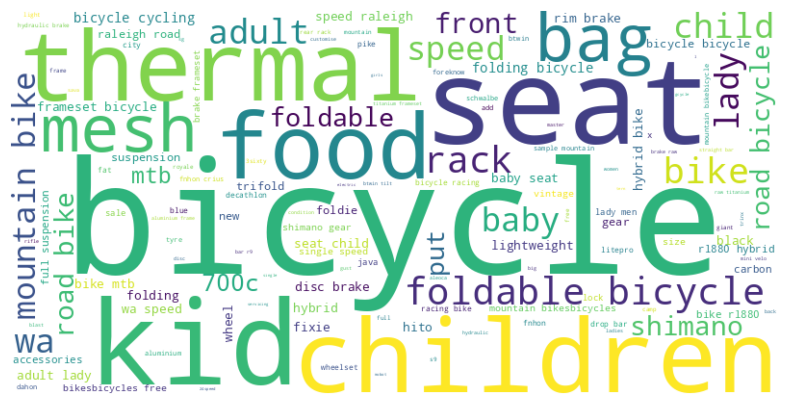

In [20]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'product_name' is your column of interest
# df = pd.read_csv('your_data.csv')  # Uncomment and replace 'your_data.csv' with your data file if needed

# Concatenate all the product names into a single string
text = " ".join(title for title in df4.product_name)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


In [21]:
import pandas as pd
from collections import Counter

# Assume df is your DataFrame and 'product_name' is your column of interest
# df = pd.read_csv('your_data.csv')  # Uncomment and replace 'your_data.csv' with your data file if needed

# Tokenize each product name into words
all_words = " ".join(df4.product_name).split()

# Count the occurrence of each word
word_counts = Counter(all_words)

# Print the words along with their counts
for word, count in word_counts.items():
    print(f'{word}: {count}')


single: 12
speed: 77
black: 17
rim: 16
wheel: 11
bicycle: 359
free: 14
coaster: 2
brake: 34
bike: 184
road: 66
speeds: 8
mountain: 70
mtb: 34
allmove: 2
fixie: 15
foldable: 92
folding: 33
dahon: 6
rifle: 4
fnhon: 13
crius: 9
hito: 14
java: 8
tern: 3
shimano: 41
litepro: 7
canyon: 2
neuron: 1
size: 9
l: 3
sale: 7
wts: 1
wtt: 1
leader: 1
fb: 1
full: 15
fixed: 2
gear: 18
aero: 2
weapon: 1
ws: 1
wheelset: 7
medium: 2
small: 2
large: 1
frame: 9
frameset: 21
set: 2
tags: 1
engine: 1
e11: 1
cinelli: 1
tsunami: 1
mash: 1
skream: 1
shukaku: 1
cranston: 4
ltt: 1
lts: 1
fs: 1
local: 1
immediate: 1
suitable: 2
children: 74
kids: 35
boys: 2
girls: 3
ready: 2
velocity: 3
gust: 4
master: 4
tornado: 2
blast: 4
monsoon: 2
zephyr: 1
tyre: 3
schwalbe: 6
chainring: 2
continental: 1
panaracer: 1
foldie: 10
fold: 3
customise: 4
sava: 4
merida: 2
trinx: 4
giant: 5
hybrid: 42
m500: 1
elite: 1
new: 12
aluminium: 10
oil: 1
slick: 1
tiagra: 2
3sixty: 5
bar: 13
trifold: 11
gcycle: 3
eg7: 2
sg: 4
professional: 1
s

In [4]:
# image processing

def get_image(url):
    response = requests.get(url)
    response.raise_for_status()
    img_data = BytesIO(response.content)
    img = Image.open(img_data)
    return img

In [5]:
def preprocess_image(img):
    img = img.convert('RGB')
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = preprocess(img)
    return img_tensor

In [6]:
url = 'https://media.karousell.com/media/photos/products/2023/10/12/fixie_bicycle_1697119201_3792ad13_progressive_thumbnail.jpg'
image = get_image(url)
processed_image_tensor = preprocess_image(image)
processed_image_tensor

tensor([[[ 0.3823,  0.3994,  0.4166,  ...,  1.5125,  1.5468,  1.1529],
         [ 0.3823,  0.4166,  0.4337,  ...,  1.5125,  1.5297,  1.1187],
         [ 0.3994,  0.4337,  0.4508,  ...,  1.4954,  1.5297,  1.0502],
         ...,
         [-0.4226, -0.4739, -0.4911,  ..., -0.4397, -0.4739, -0.4739],
         [-0.3712, -0.4226, -0.4054,  ..., -0.4911, -0.4911, -0.5253],
         [-0.2856, -0.3712, -0.3369,  ..., -0.4568, -0.4568, -0.4739]],

        [[ 0.6254,  0.6429,  0.6604,  ...,  1.7108,  1.7458,  1.3431],
         [ 0.6254,  0.6604,  0.6779,  ...,  1.7108,  1.7283,  1.3081],
         [ 0.6429,  0.6779,  0.6954,  ...,  1.6933,  1.7283,  1.2381],
         ...,
         [-0.3725, -0.4251, -0.4426,  ..., -0.2675, -0.3025, -0.3025],
         [-0.3200, -0.3725, -0.3550,  ..., -0.3200, -0.3200, -0.3550],
         [-0.2325, -0.3200, -0.2850,  ..., -0.2850, -0.2850, -0.3025]],

        [[ 0.7751,  0.7925,  0.8099,  ...,  1.8731,  1.9080,  1.5071],
         [ 0.7751,  0.8099,  0.8274,  ...,  1

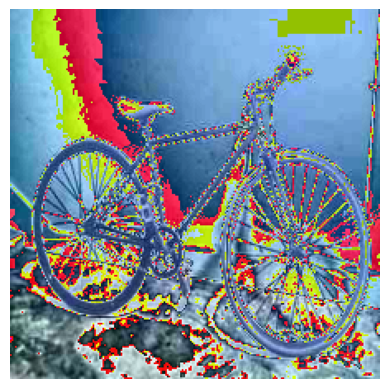

In [7]:
def tensor_to_image(tensor):
    img = to_pil_image(tensor)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

tensor_to_image(processed_image_tensor.squeeze())

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1)
    return embedding.detach().numpy()

In [20]:
product_title_embedding = get_text_embedding("fnhon foldable bicycle")
product_desc_embedding = get_text_embedding("sell fnhon foldable bicycle be on the road less then time disc brake and shimano gear each")

In [39]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model.eval()

def get_image_embedding(img_url):
    img = get_image(img_url)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        embedding = model(img_tensor)
    return embedding.squeeze().detach().numpy()


url = 'https://media.karousell.com/media/photos/products/2023/10/12/fixie_bicycle_1697119201_3792ad13_progressive_thumbnail.jpg'
image_embedding = get_image_embedding(url)
image_embedding

/Users/daaa/Downloads/AICU-APP/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daaa/Downloads/AICU-APP/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


array([0.26267794, 1.1283611 , 0.14720105, ..., 0.00929206, 0.04974468,
       0.69566834], dtype=float32)

In [17]:
image_embedding

array([0.26267794, 1.1283611 , 0.14720105, ..., 0.00929206, 0.04974468,
       0.69566834], dtype=float32)

In [28]:
print("shape of image embedding:", image_embedding.shape)
print("shape of product title embedding:", product_title_embedding.shape) 
print("shape of product desc embedding:", product_desc_embedding.shape)

shape of image embedding: torch.Size([2048])
shape of product title embedding: torch.Size([768])
shape of product desc embedding: torch.Size([768])


In [47]:
# combine using weights + standardize dimensions

def combine_embeddings(product_title_embedding, product_desc_embedding, image_embedding):
    product_title_embedding = torch.tensor(product_title_embedding, dtype=torch.float32)
    product_desc_embedding = torch.tensor(product_desc_embedding, dtype=torch.float32)
    image_embedding = torch.tensor(image_embedding, dtype=torch.float32)

    fc_title = nn.Linear(768, 512)
    fc_desc = nn.Linear(768, 512)
    fc_image = nn.Linear(2048, 512)

    product_title_embedding_512 = fc_title(product_title_embedding)
    product_desc_embedding_512 = fc_desc(product_desc_embedding)
    image_embedding_512 = fc_image(image_embedding)

    product_title_embedding_normalized = torch.nn.functional.normalize(product_title_embedding_512, p=2, dim=0)
    product_desc_embedding_normalized = torch.nn.functional.normalize(product_desc_embedding_512, p=2, dim=0)
    image_embedding_normalized = torch.nn.functional.normalize(image_embedding_512, p=2, dim=0)

    weight_image = 0.5
    weight_title = 0.25
    weight_desc = 0.25

    weighted_title_embedding = weight_title * product_title_embedding_normalized
    weighted_desc_embedding = weight_desc * product_desc_embedding_normalized
    weighted_image_embedding = weight_image * image_embedding_normalized

    combined_embedding = weighted_title_embedding + weighted_desc_embedding + weighted_image_embedding

    return combined_embedding

In [51]:
embedding = combine_embeddings(product_title_embedding, product_desc_embedding, image_embedding)

/var/folders/90/q7dj_p6j3gx0cls87s3y0myc0000gq/T/ipykernel_17439/115182218.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  product_title_embedding = torch.tensor(product_title_embedding, dtype=torch.float32)
/var/folders/90/q7dj_p6j3gx0cls87s3y0myc0000gq/T/ipykernel_17439/115182218.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  product_desc_embedding = torch.tensor(product_desc_embedding, dtype=torch.float32)


In [57]:
df = pd.read_csv("carousell_cleaned_final.csv")
print(df.columns)
print(len(df))

Index(['market_link', 'product_name', 'img_url', 'listing_upload_date',
       'condition', 'description', 'market'],
      dtype='object')
320


In [ ]:
batch_size = 32

for i in range(0, len(df), batch_size):
    i_end = min(len(data), i+batch_size)
    batch = df.iloc[i:i_end]
    ids = [f"{df['market_link']}" for i, x in batch.iterrows()]
    texts = [x['chunk'] for i, x in batch.iterrows()]
    embeds = embed_model.embed_documents(texts)
    # get metadata to store in Pinecone
    metadata = [
        {'text': x['chunk'],
         'source': x['source'],
         'title': x['title']} for i, x in batch.iterrows()
    ]
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))